<a href="https://www.kaggle.com/code/jacker01/house-prices-prediction?scriptVersionId=150590980" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## House prices prediction using xgboost,linear regression, decision trees & cross-validation

This notebook aims to predict house prices for the house-prices-advanced-regression-techniques kaggle competition.
My models have currently achieved:
* Linear regression = 0.1435 rmse(scaled down) **Best performer**.
* Decision tree regressor = 0.156 rmse.
* Xgboost regressor = 0.15179 rmse.

Leaderboard =  1993 / 4696

# Importing libraries and writing custom functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows',None)

warnings.filterwarnings('ignore') #outputs will not show warnings

**Some custom functions i always use.**

In [3]:
def quick_check(data):
    data_nulls = data.isna().sum()
    total_rows = len(data)
    
    nulls_dict = {}
    
    for column, count in data_nulls.items():
        if count > 0:
            percentage = round((count / total_rows) * 100, 1)
            nulls_dict[column] = percentage
    
    Table = pd.DataFrame.from_dict(nulls_dict, orient='index', columns=['Percentage Missing'])
    return Table.sort_values('Percentage Missing',ascending=False)

In [4]:
def really_num(data):
    lis=[]
    li2=[]
    for i,column in enumerate(data):
        if len(data[column].unique()) < 20:
            lis.append(column)
        else:
            li2.append(column)
    return lis
        

In [5]:
def categorize_cols(data):
    numeric = data.select_dtypes(include=[np.number])
    categorical = data.select_dtypes(include = object)
    return numeric,categorical

# Loading the data and first look

In [6]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [7]:
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [8]:
display(train.head(8))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning

In [10]:
quick_check(train) # looking at the percentage of nulls in our dataset

,Percentage Missing
PoolQC,99.5
MiscFeature,96.3
Alley,93.8
Fence,80.8
MasVnrType,59.7
FireplaceQu,47.3
LotFrontage,17.7
GarageType,5.5
GarageYrBlt,5.5
GarageFinish,5.5


#### Some columns have na reffering the a lack of that feature rather than the data being missing

In [11]:
#PoolQC, here na means no pool 
train['PoolQC'] = train['PoolQC'].fillna('NO')
test['PoolQC'] = test['PoolQC'].fillna('NO')

In [12]:
#'MiscFeature', here na means no pool 
train['MiscFeature'] = train['MiscFeature'].fillna('NO')
test['MiscFeature'] = test['MiscFeature'].fillna('NO')

In [13]:
#'Alley', na means no alley
train['Alley'] = train['Alley'].fillna('NO')
test['Alley'] = test['Alley'].fillna('NO')

In [14]:
train['Fence'] = train['Fence'].fillna('NO')
test['Fence'] = test['Fence'].fillna('NO')

In [15]:
train['MasVnrType'] = train['MasVnrType'].fillna('No')
test['MasVnrType'] = test['MasVnrType'].fillna('No')

In [16]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('No')
test['FireplaceQu'] = test['FireplaceQu'].fillna('No')

In [17]:
train['LotFrontage'] = train['LotFrontage'].fillna(train.groupby('Neighborhood')['LotFrontage'].transform('median'))

test['LotFrontage'] = test['LotFrontage'].fillna(test.groupby('Neighborhood')['LotFrontage'].transform('median'))


In [18]:
train['GarageType'] = train['GarageType'].fillna('No')
test['GarageType'] = test['GarageType'].fillna('No')

In [19]:
train['GarageFinish'] = train['GarageFinish'].fillna('No')
test['GarageFinish'] = test['GarageFinish'].fillna('No')

train['GarageCond'] = train['GarageCond'].fillna('No')
test['GarageCond'] = test['GarageCond'].fillna('No')

train['GarageQual'] = train['GarageQual'].fillna('No')
test['GarageQual'] = test['GarageQual'].fillna('No')

In [20]:
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No')

In [21]:
train['BsmtExposure'] = train['BsmtExposure'].fillna('No')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No')

In [22]:
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No')

In [23]:
train['BsmtCond'] = train['BsmtCond'].fillna('No')
test['BsmtCond'] = test['BsmtCond'].fillna('No')

train['BsmtQual'] = train['BsmtQual'].fillna('No')
test['BsmtQual'] = test['BsmtQual'].fillna('No')

In [24]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [25]:
quick_check(train)

,Percentage Missing
GarageYrBlt,5.5
Electrical,0.1


In [26]:
# Finally drop the rows that are truly null
train = train.drop(['Electrical','GarageYrBlt','Id'],axis=1)

In [27]:
quick_check(train)

,Percentage Missing


In [28]:
train.shape

(1460, 78)

# EDA

In [29]:
num_cols,cat_cols = categorize_cols(train) # Create seperate dfs for categorical and numerical features

In [30]:
num_cols.shape

(1460, 36)

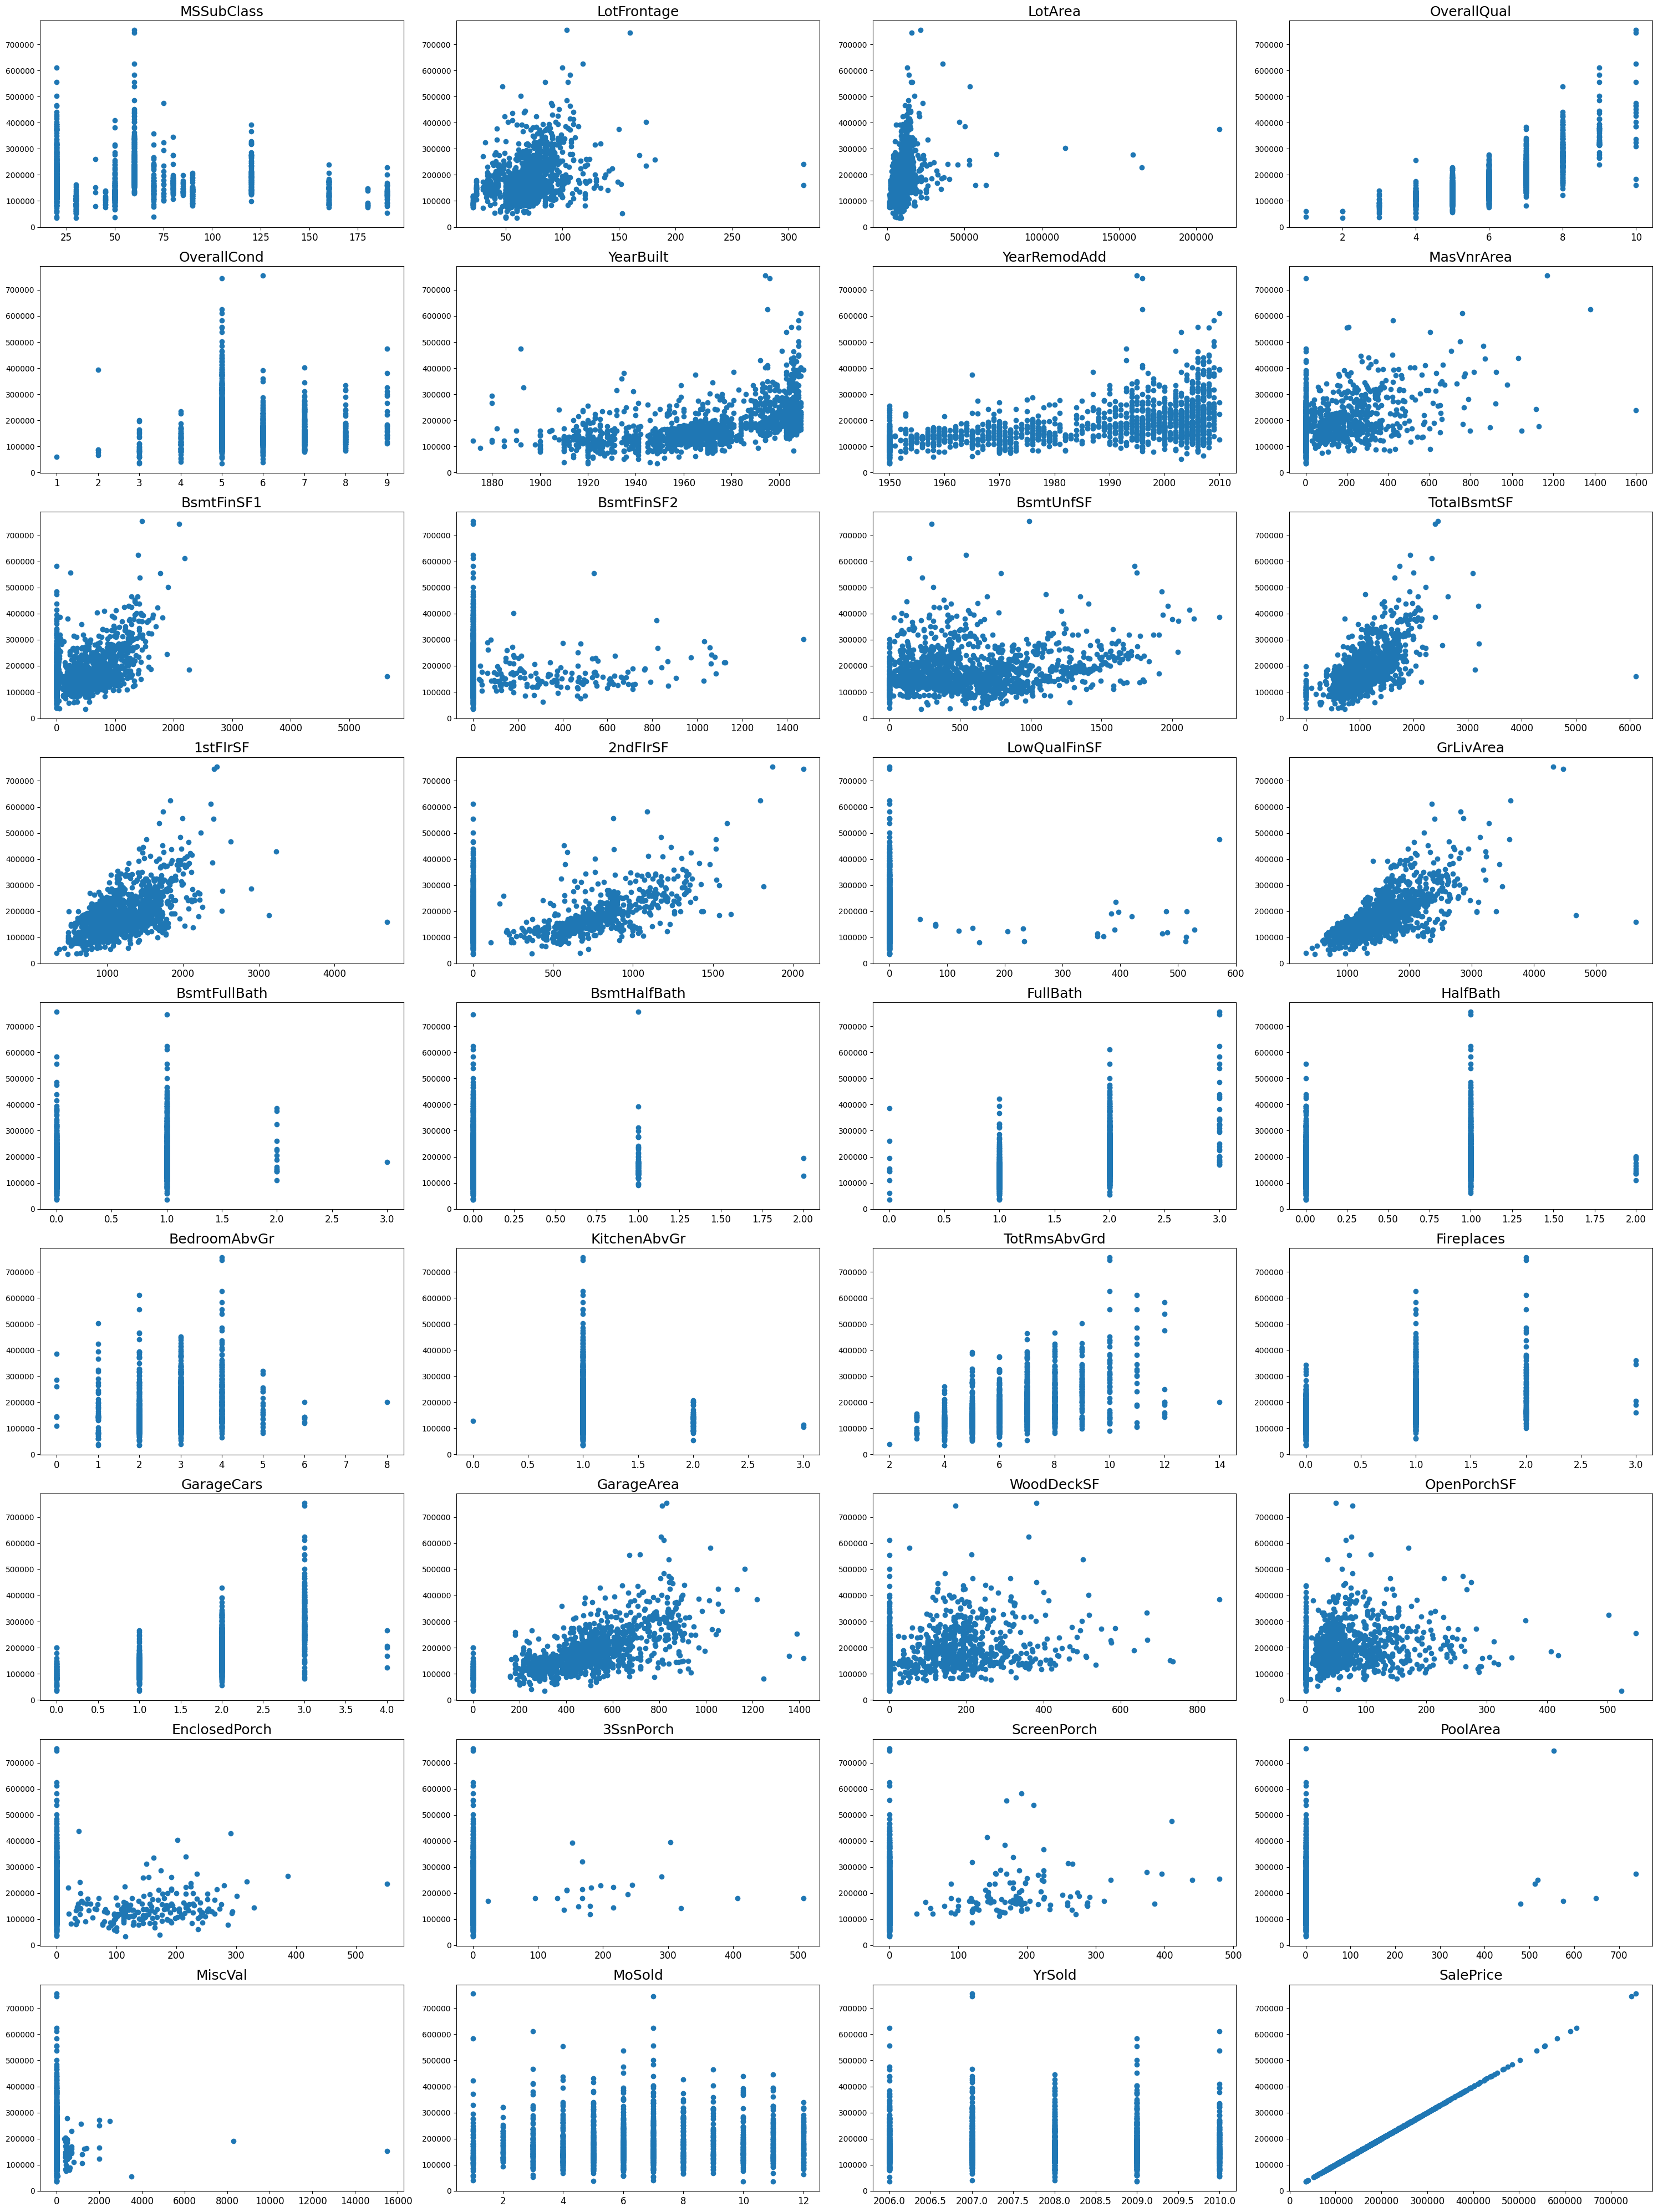

In [31]:
fig, axes = plt.subplots(9, 4, figsize=(30, 40))  # Adjust figsize as needed

# Flatten the 3x12 array of axes to simplify iteration
axes = axes.flatten()

# Iterate through numeric columns and create scatter plots
for i, (col_name, col_data) in enumerate(num_cols.items()):
    ax = axes[i]
    ax.scatter(x=col_data, y=train['SalePrice'])
    ax.set_title(col_name, fontsize=18)
    ax.tick_params(axis='x', labelsize=12)  # Set the x-axis tick fontsize

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()


# Feature preprocessing

## Label encoding
This could have yielded better results if i onehotencoded non ordinal data rather than using labelencoding only

In [32]:
confirm_num = really_num(num_cols) #creates a list of 'supposed' numerical features with very few unique values
for i in confirm_num:
    print(i,train[i].unique()) #Shows us the features and their unique values


MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
OverallCond [5 8 6 7 4 2 3 9 1]
BsmtFullBath [1 0 2 3]
BsmtHalfBath [0 1 2]
FullBath [2 1 3 0]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [1 2 3 0]
TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces [0 1 2 3]
GarageCars [2 3 1 0 4]
PoolArea [  0 512 648 576 555 480 519 738]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold [2008 2007 2006 2009 2010]


In [33]:
to_conv = ["MSSubClass","OverallQual","OverallCond","MoSold","YrSold"]
train[to_conv] = train[to_conv].astype(object) # converts the features we've confirmed aren't numerical into object dtype
num_cols,cat_cols = categorize_cols(train) #Updating the lists of features

In [34]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for i,col in enumerate(cat_cols):
    train[col] = label.fit_transform(train[col])

In [35]:
train['SalePrice'] = np.log1p(train['SalePrice'])

# Removing Outliers

In [36]:
from scipy import stats
# using the zscore to determine and remove outliers
for i in num_cols:
    z_scores = stats.zscore(train[i]) 
    if (z_scores > 4 ).any():
        train = train.drop(train.index[z_scores > 4])
    elif (z_scores < -4 ).any():
        train = train.drop(train.index[z_scores < -4])
    else:
        pass

In [37]:
list(train[train['YearBuilt']<1900].index)

[106, 716, 945, 991, 1132, 1137]

In [38]:
list(train[train['LotArea']>20000].index)

[171,
 411,
 417,
 422,
 558,
 563,
 588,
 661,
 664,
 692,
 848,
 876,
 1010,
 1048,
 1057,
 1260,
 1270,
 1287,
 1383,
 1409,
 1430,
 1446]

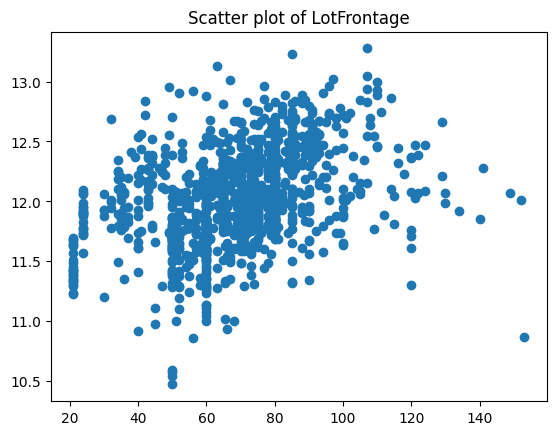

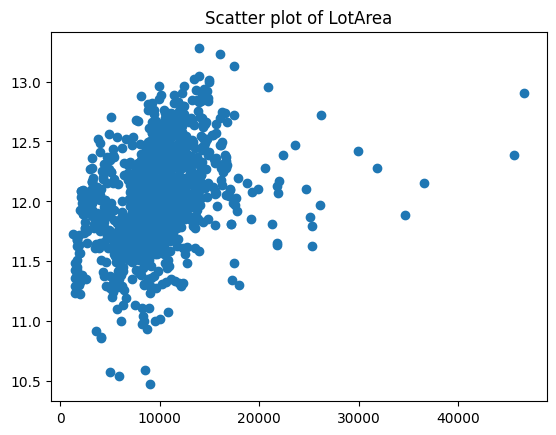

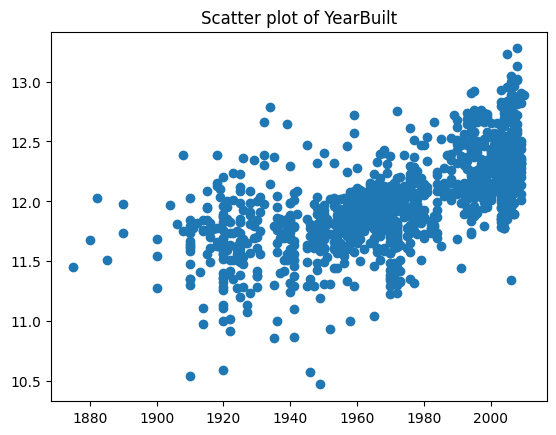

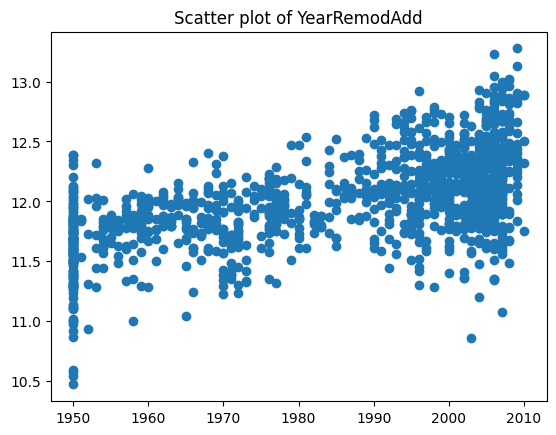

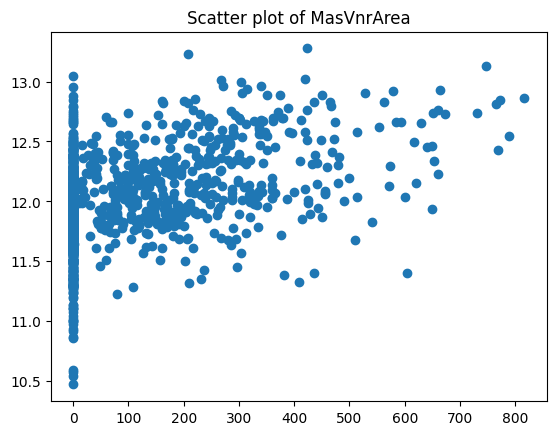

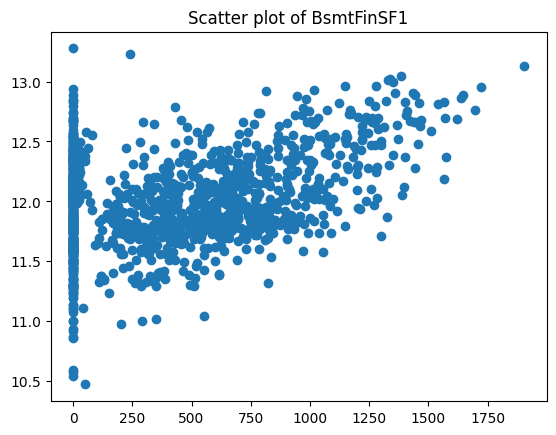

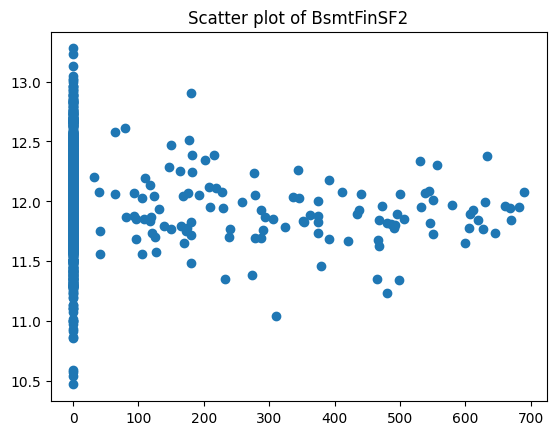

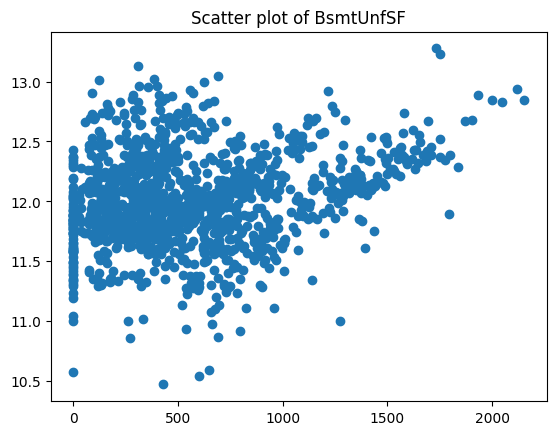

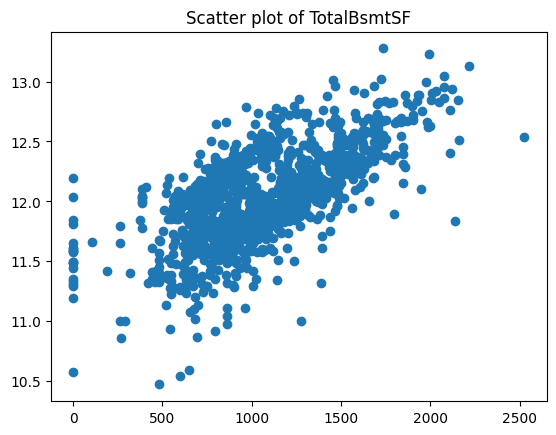

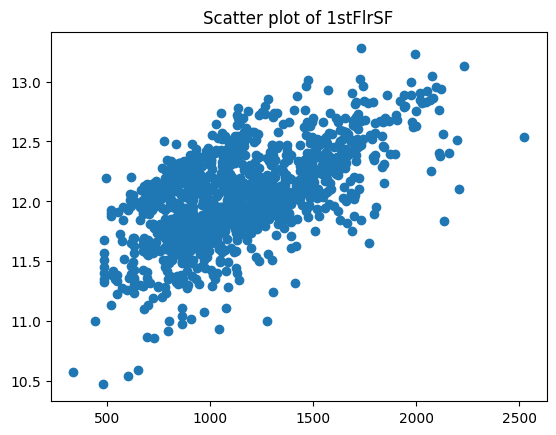

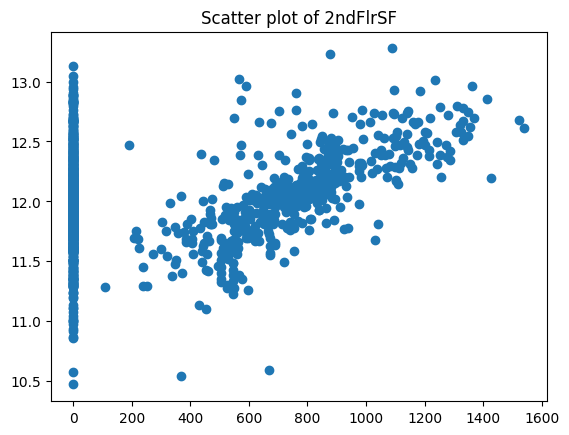

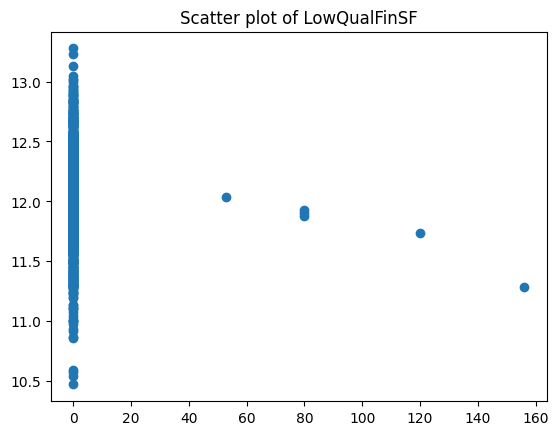

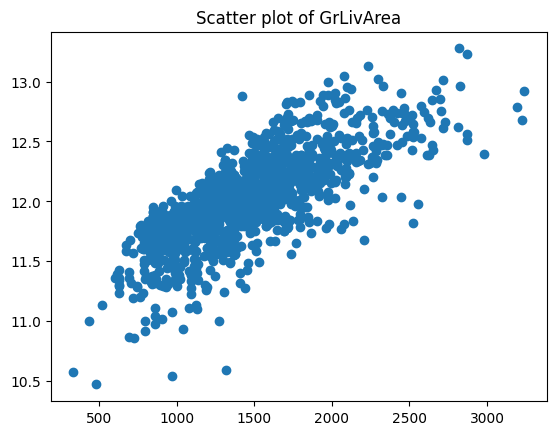

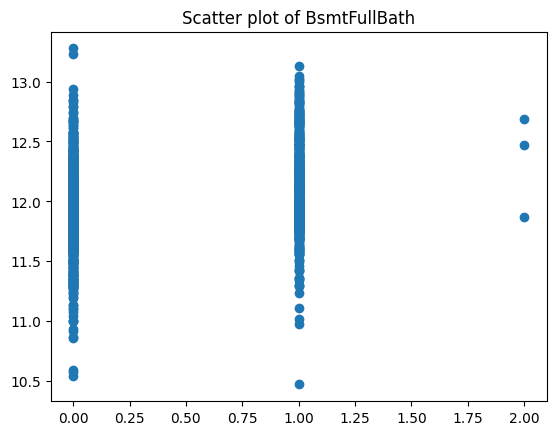

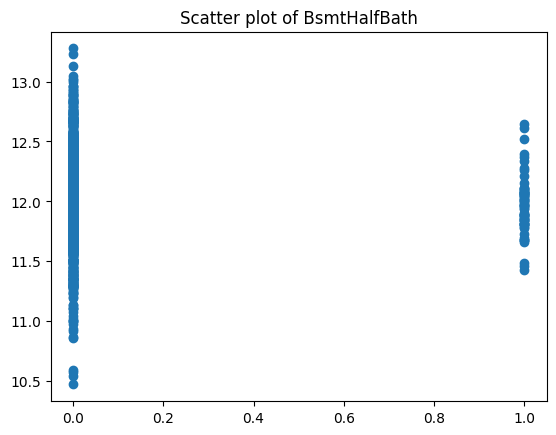

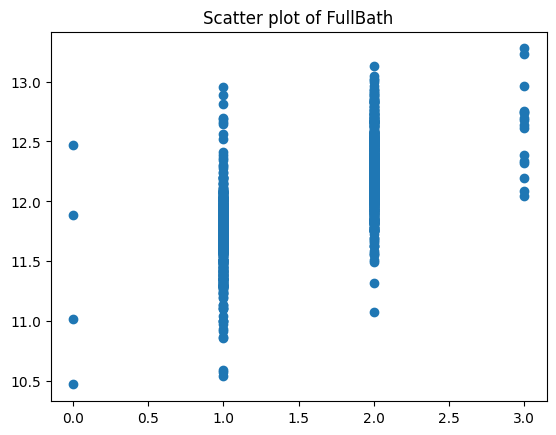

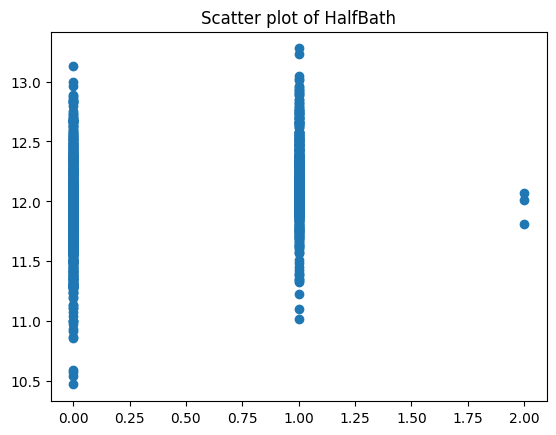

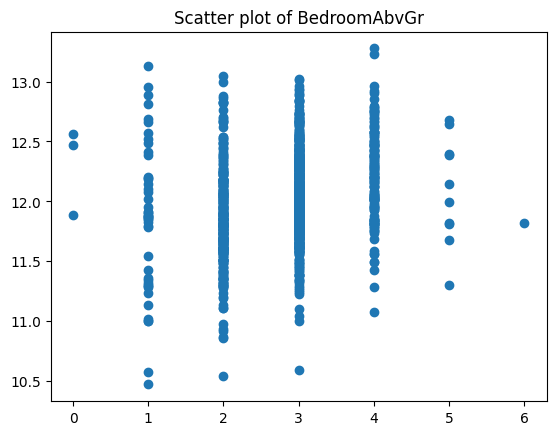

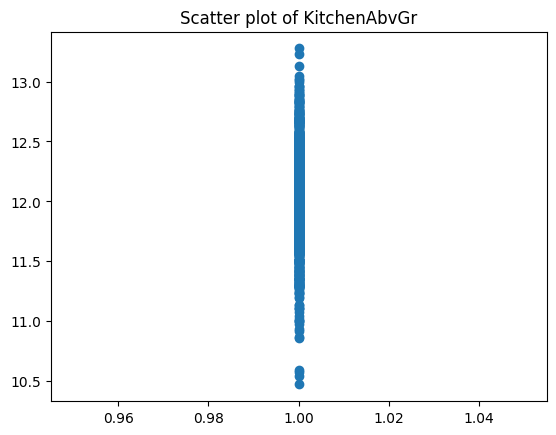

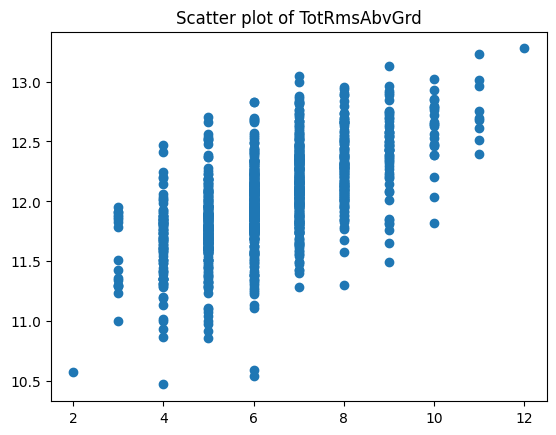

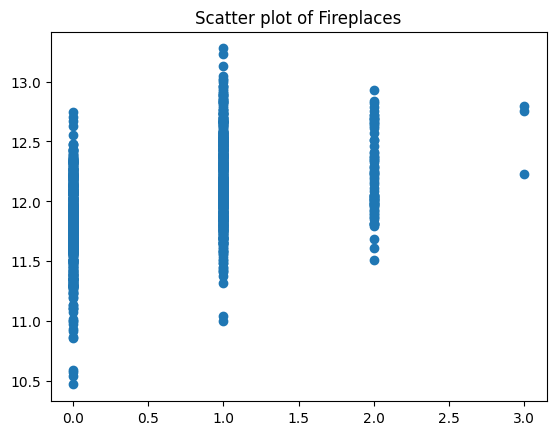

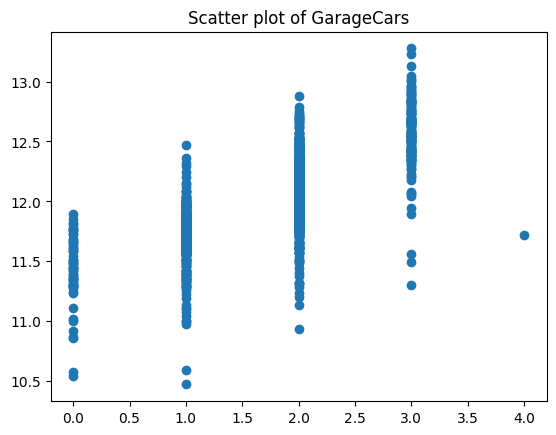

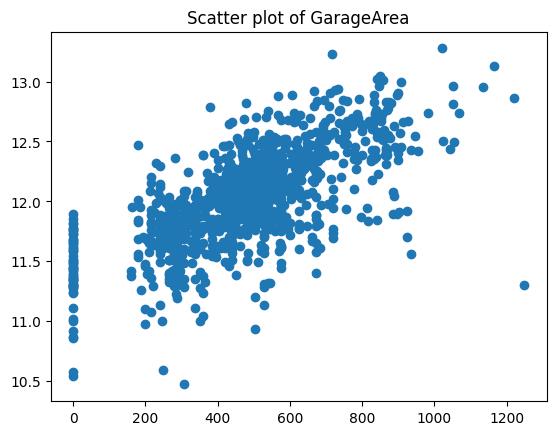

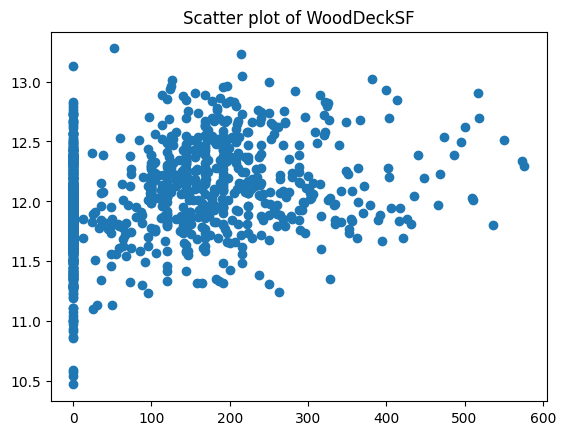

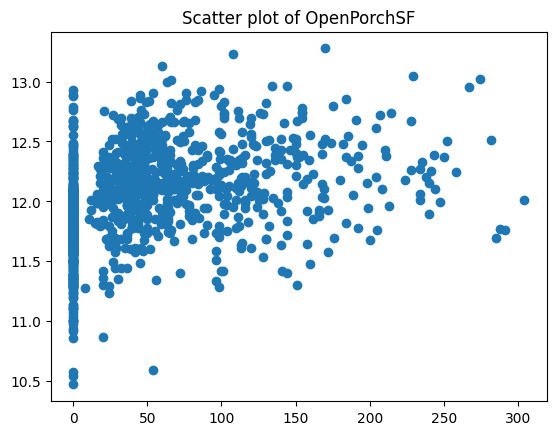

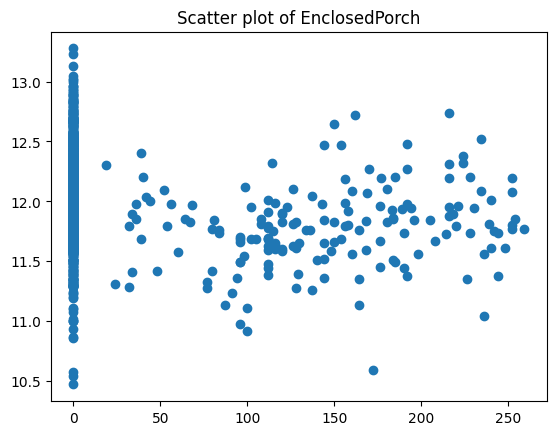

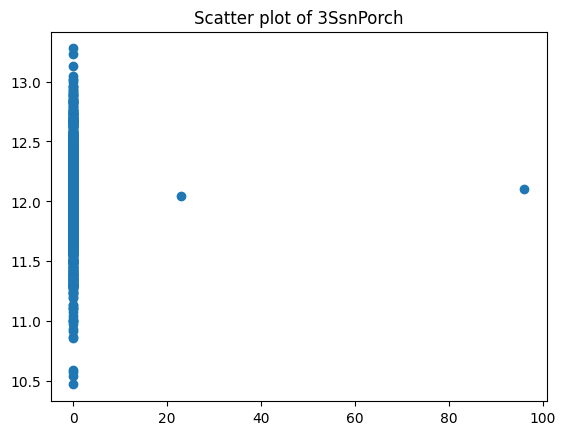

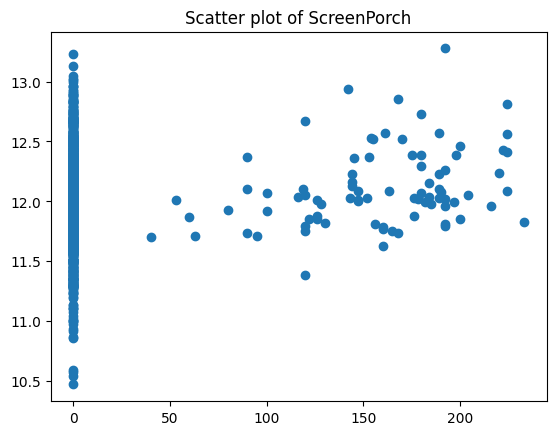

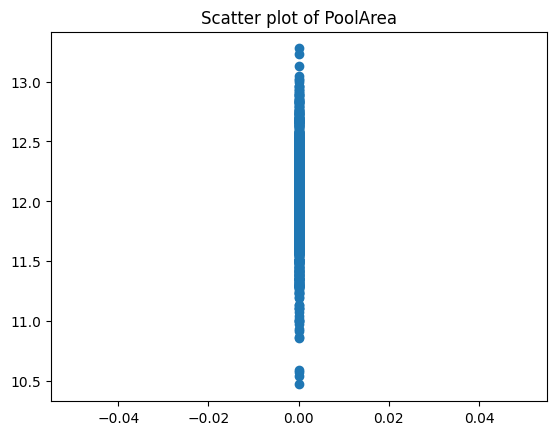

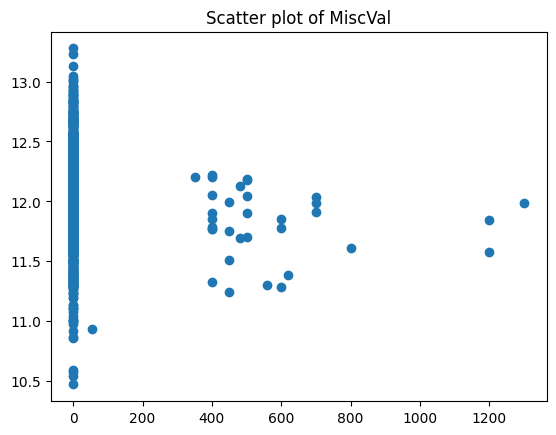

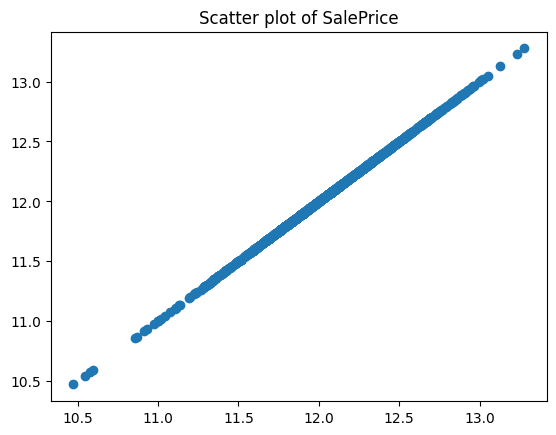

In [39]:
for i,col in enumerate(num_cols):
    plt.scatter(x=train[col],y=train['SalePrice'])
    plt.title(f"Scatter plot of {col}")
    plt.show()



In [40]:
num_cols.shape

(1460, 31)

Splitting into feature and target matrix

In [41]:
x = train.drop(['SalePrice'],axis=1)
filterr = x.columns
y = train['SalePrice']
y = np.ravel(y)

# Feature Selection (RFE)

In [42]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor 
n_features_to_select=50
lr = DecisionTreeRegressor()
rfe = RFE(estimator=lr,n_features_to_select = n_features_to_select)
rfe.fit(x,y)
selected = filterr[rfe.get_support()]
rank = rfe.ranking_
dictt = {k: v for k, v in zip(selected, rank)}


vizualizing feature importance scores.
- **The lower the score the better (1 is very high)**

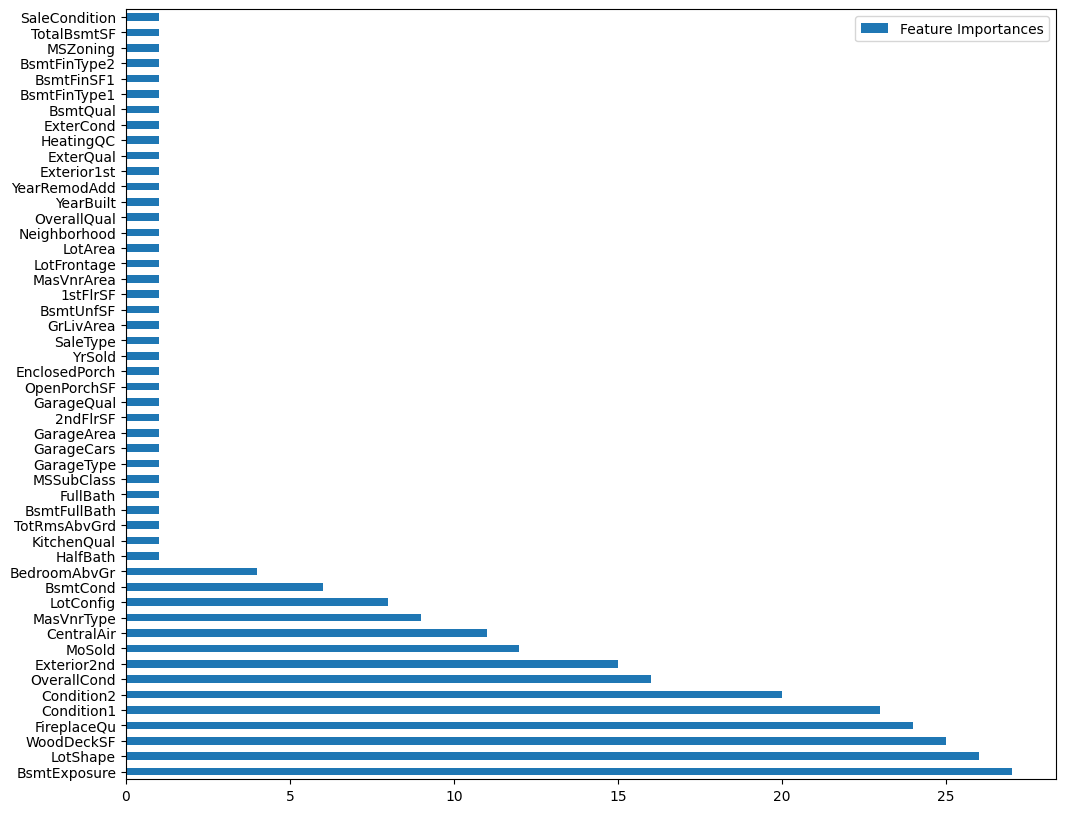

In [43]:
rank = rfe.ranking_
dictt = {k: v for k, v in zip(selected, rank)}
imp_df = pd.DataFrame.from_dict(dictt,orient='index',columns=['Feature Importances'])
imp_df.sort_values('Feature Importances',ascending=False).plot(kind='barh')
plt.gcf().set_size_inches(12,10)

## Scaling

In [44]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x = train[selected]
num_cols,cat_cols = categorize_cols(x)
x[list(num_cols.columns)] = scale.fit_transform(x[list(num_cols.columns)])

In [45]:
train.shape

(1235, 78)

# Model selection

splitting into train and validation dataset

In [46]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=55)
print(x_train.shape,y_train.shape)

(864, 50) (864,)


# Model 1(Best Performer) -> Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Create and fit the linear regression model
l = LinearRegression()
l.fit(x_train, y_train)

# Make predictions on the test data
y_pred = l.predict(x_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

0.12000061401309453


**Rmse of 0.14385 on test data** (note rmse is scaled down for test data)

# Model 2 -> Decision Tree Regressor using GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

dtr = DecisionTreeRegressor(random_state=45)

# Define a grid of hyperparameters to search
param_grid = {
    'criterion': ['poisson','squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [None, 3,5,6,8],
    'min_samples_split': [2,4,6],
    'min_samples_leaf':[1,2,4,6,7],# Adjust the values as needed
}

# Create the GridSearchCV object
grid_search_dtr = GridSearchCV(dtr, param_grid, cv=3,scoring='neg_root_mean_squared_error')

# Fit the grid search to the training data
grid_search_dtr.fit(x_train, y_train)

# Get the best model from the grid search
best_model_dtr = grid_search_dtr.best_estimator_

# Evaluate the best model on the test set
r2_score = best_model_dtr.score(x_test, y_test)

print("Best R-squared Score:", r2_score)
c = best_model_dtr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, c))
print(rmse)

Best R-squared Score: 0.768809353527249
0.1791085736838087


**Rmse of 0.156 on test data**

# Model 3 -> XGB Regressor using GridSearchCV 

In [49]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()

param_grid = {
    'booster': ['gbtree', 'gblinear','dart'],
    'max_depth': [3, 5, 6, 8],
    'subsample': [0.5, 0.7, 1],  # Fix the typo here
    'lambda': [1, 6, 10],
    'alpha': [1, 6, 10],
    'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:pseudohubererror', 'reg:absoluteerror', 'reg:quantileerror']
    # Adjust the values as needed
}

# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=3)

# Fit the grid search to the training data
grid_search_xgb.fit(x_train, y_train)

# Get the best model from the grid search
best_model_xgb = grid_search_xgb.best_estimator_

# Evaluate the best model on the test set
r2_score = best_model_xgb.score(x_test, y_test)

print("Best R-squared Score:", r2_score)
rmse = np.sqrt(mean_squared_error(y_test, best_model_xgb.predict(x_test)))
print(rmse)


[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[23:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.



**Rmse of 0.15179 on test data**

In [50]:
grid_search_xgb.best_params_

{'alpha': 1,
 'booster': 'dart',
 'lambda': 1,
 'max_depth': 3,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

# XGB Regressor hyperparameters(If you dont want to run grid search yourself):
**{'alpha': 10,
 'booster': 'gbtree',
 'lambda': 6,
 'max_depth': 3,
 'objective': 'reg:squarederror',
 'subsample': 0.7}**

# Prepping the test data

In [51]:
t = test

In [52]:
test = test[selected]

In [53]:
quick_check(test)

,Percentage Missing
MSZoning,0.3
Exterior1st,0.1
Exterior2nd,0.1
BsmtFinSF1,0.1
BsmtUnfSF,0.1
TotalBsmtSF,0.1
BsmtFullBath,0.1
KitchenQual,0.1
GarageCars,0.1
GarageArea,0.1


In [54]:
test['GarageArea'] = test['GarageArea'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
#test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)


In [55]:
test_num,test_cat = categorize_cols(test)
confirm_cat = really_num(test_num)
for i in confirm_cat:
    print(i,test[i].unique())


MSSubClass [ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]
OverallQual [ 5  6  8  7  4  9  2  3 10  1]
OverallCond [6 5 7 8 2 9 3 4 1]
BsmtFullBath [ 0.  1.  2.  3. nan]
FullBath [1 2 3 4 0]
HalfBath [0 1 2]
BedroomAbvGr [2 3 4 1 6 5 0]
TotRmsAbvGrd [ 5  6  7  4 10  8  9  3 12 11 13 15]
GarageCars [1. 2. 3. 0. 4. 5.]
MoSold [ 6  3  1  4  5  2  7 10  8 11  9 12]
YrSold [2010 2009 2008 2007 2006]


In [56]:
to_conv = ["MSSubClass","OverallQual","OverallCond","MoSold","YrSold"]
test[to_conv] = test[to_conv].astype(object)
test_num,test_cat = categorize_cols(test)

In [57]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for i,col in enumerate(test_cat):
    test[col] = label.fit_transform(test[col])

In [58]:
test_num, test_cat = categorize_cols(test)

for column in test.columns:
    if column in cat_cols:
        # For categorical columns, fill missing values with the mode
        test[column] = test[column].fillna(test[column].mode().iloc[0])
    else:
        # For numerical columns, fill missing values with the median
        test[column] = test[column].fillna(test[column].median())

In [59]:
test[test_num.columns] = scale.fit_transform(test[num_cols.columns])

In [60]:
model = l

# Making predictions

In [61]:
def makepred(test_data,pid):
    model.fit(x,y)
    preds = model.predict(test_data)
    if len(preds) == len(t):
        new_df = pd.DataFrame({'Id': t['Id']})
        new_df['SalePrice'] = preds
        new_df['SalePrice'] = np.expm1(new_df['SalePrice'])
        new_df.to_csv('SUBMISSIONf.csv', index=False)
        return"All is well"
    else:
        print(len(preds),len(z))
        return"error predictions and id's not same shape"

In [62]:
makepred(test,"test.csv")

'All is well'